In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
import time


In [2]:
# cell to keep functions
# encode dataset
def encode(df, type = ''):

    if type == 'numeric':
        # encoder - get numeric categories
        lb_make = LabelEncoder()
        df_num = pd.DataFrame()
        for col in df.columns:
            df_num[col] = lb_make.fit_transform(df[col].astype('str'))

    elif type == 'dummies':
        # encoder - get dummy variables
        list_of_dummies = []
        for col in df.columns:
            dummy = pd.get_dummies(df[col]).rename(columns=lambda x: 'Category_' + str(x))
            list_of_dummies.append(dummy)
        df_num = pd.concat(list_of_dummies, axis = 1)
    else:
        print('Error in encode_df: wrong choise of type')
        df_num = pd.DataFrame([1])

    df_num.index = df.index
    df_num = df_num.fillna(0)

    return df_num

    
    

In [8]:
# import and structure data
columns =  list(np.arange(8,98,3))
columns.append(5)

data = pd.read_excel('Totaloversikt.xlsx', sheet_name='Totaloversikt', usecols=columns, skiprows=0)

# drop columns and transpose
data = data.drop(index=[0,1,2,104,105,106]).reset_index().drop(columns='index').transpose()

# import column for points and fasit
points = pd.read_excel('Totaloversikt.xlsx', sheet_name='Totaloversikt', usecols="E").drop(index=101)

# modify belays (fixed when scoring points) 
belay_ids = [[24,25], [28,29], [31,32], [34,35,36,37], [44,45,46,47], [59,60,61,62], 
             [64,65,66,67], [75,76,77,78], [85,86,87,88] ]

for i in belay_ids: 
    for j in i:
        points.loc[j-1, 'Poeng'] = points.loc[j-1, 'Poeng'] - 1 

# encode
numeric = encode(data,'numeric')
dummies = encode(data, 'dummies')

# fill nans in numeric fasit
numeric.loc['Mr. Fasit', data.loc['Mr. Fasit',:].isna()] = 99999

# as integer
#numeric.loc[numeric.index != 'Mr. Fasit', :] = numeric.loc[numeric.index != 'Mr. Fasit', :].astype('int')
        
# get majority vote
l = []
for i in numeric.columns:
    l.append( numeric.iloc[:,i].value_counts().index[0] )
majority_vote = pd.DataFrame(l).transpose()
display(majority_vote)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,3,4,1,3,1,0,0,1,1,0,...,2,1,2,6,1,0,0,5,1,0


In [16]:
# get individual scores:

# del
numeric = encode(data,'numeric')
dummies = encode(data, 'dummies')

# fill nans in numeric fasit
numeric.loc['Mr. Fasit', data.loc['Mr. Fasit',:].isna()] = 99999
# ---
# replace nan with random number
idx = numeric.loc['Mr. Fasit',:] == 99999
score = pd.DataFrame(index=data.index).drop(index='Mr. Fasit')

start = time. time()
# run simulation

ignore_belays=True # slow in simulations
n_sim = 10000
for iter in range(n_sim):
    score_iter = 'score_'+str(iter)
    
    if np.random.random() < 0.5:
        # random winner 
        numeric.loc['Mr. Fasit',idx==True] = np.random.randint(4, size=idx.sum())
    else:
        # majority vote
        numeric.loc['Mr. Fasit',idx==True] = majority_vote.loc[0,idx==True]
    
    # calculate score
    for i in score.index:
        s = numeric.loc[i,:] == numeric.loc['Mr. Fasit',:] 
        sc = s * points['Poeng']
        score.loc[i,score_iter]=sc.sum()
        
        if not ignore_belays:
            # modify belays - slow af
            for j in belay_ids: 
                for k in j:
                    if numeric.loc[i, k] in numeric.loc['Mr. Fasit', j]:
                        # add score for correct skier in belay
                        score.loc[i,score_iter] = score.loc[i,score_iter] + 1
                        # test me (!!)
                        

end = time.time()   

print(end-start)
score['mean'] = score.mean(axis=1)
score['std'] = score.std(axis=1)

score=score.sort_values(by='mean',ascending=False)
display(score.loc[:,['mean','std']])

385.30651903152466


,mean,std
Andørs Emmkø,182.0411,98.538881
Mari Astrid & Rune,178.7383,92.890521
Sigurd Haga,170.7108,93.873316
Mox,169.3942,89.239357
Steinar Holtskog,162.4564,73.301559
Juan Antonio,160.5673,82.042300
Øystein T,157.4784,78.193548
Tim Mujo,154.2178,73.496634
<FrøydisEven>,153.9274,74.836352
Petter Linstad,153.0049,74.665389


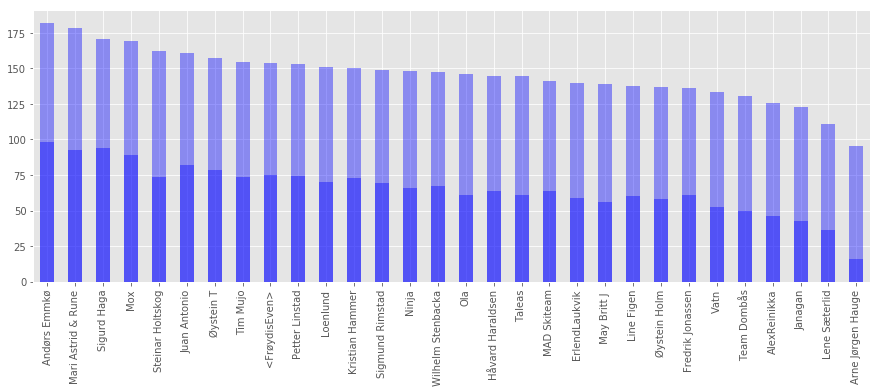

In [18]:
score['mean'].plot(kind='bar', figsize=(15,5), color='blue',alpha=0.4)
score['std'].plot(kind='bar', figsize=(15,5), color='blue',alpha=0.4)


In [62]:
n_sim=10000
l = []
ranks = pd.DataFrame()
for i in range(n_sim):
    ranks[str(i)] = score.iloc[:,i].argsort()
print(ranks.shape)
display(((ranks == 30).astype(int).sum(axis=1) / n_sim).sort_values() )


(30, 10000)


Andørs Emmkø          0.0020
Mari Astrid & Rune    0.0033
Sigurd Haga           0.0046
Mox                   0.0070
Steinar Holtskog      0.0078
Juan Antonio          0.0093
Øystein T             0.0112
Tim Mujo              0.0116
<FrøydisEven>         0.0138
Petter Linstad        0.0167
Janagan               0.0168
Ninja                 0.0173
Lene Sæterlid         0.0177
Sigmund Rimstad       0.0184
Loenlund              0.0188
AlexReinikka          0.0188
Kristian Hammer       0.0189
Wilhelm Stenbacka     0.0197
Ola                   0.0202
ErlendLaukvik         0.0211
Håvard Haraldsen      0.0215
Team Dombås           0.0217
Vatn                  0.0222
 May Britt J          0.0229
MAD Skiteam           0.0230
Øystein Holm          0.0235
Fredrik Jonassen      0.0245
Taleas                0.0259
Line Figen            0.0267
Arne Jørgen Hauge     0.5131
dtype: float64

In [64]:
display( ((ranks == 29).astype(int).sum(axis=1) / n_sim).sort_values(ascending=False) )


Andørs Emmkø          0.5462
Arne Jørgen Hauge     0.0634
Lene Sæterlid         0.0348
Janagan               0.0272
Mari Astrid & Rune    0.0222
Sigurd Haga           0.0196
AlexReinikka          0.0193
Mox                   0.0149
Team Dombås           0.0139
Vatn                  0.0139
Fredrik Jonassen      0.0138
Øystein Holm          0.0135
Øystein T             0.0134
Juan Antonio          0.0123
<FrøydisEven>         0.0119
Steinar Holtskog      0.0119
Taleas                0.0118
Line Figen            0.0117
Petter Linstad        0.0112
MAD Skiteam           0.0111
Ninja                 0.0110
Håvard Haraldsen      0.0110
Kristian Hammer       0.0107
Loenlund              0.0103
Ola                   0.0102
 May Britt J          0.0101
Wilhelm Stenbacka     0.0101
Tim Mujo              0.0097
ErlendLaukvik         0.0096
Sigmund Rimstad       0.0093
dtype: float64